In [1]:
# Dependencies
%matplotlib inline
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import scipy.stats as st
from scipy.stats import linregress
import seaborn as sns
import numpy as np

In [2]:
# Vaccine Data - see notebooks in 'Amy' branch for more detailed cleaning
VaccineData = "covid19_vaccinations_in_the_united_states_07Feb2021.csv"

In [3]:
# Read and display the CSV
Vax_df = pd.read_csv(VaccineData)
Vax_df.head()

,State,Unnamed: 1,Tot_Deliv,Tot_Admin,Deliv_per_100K,Admin_per_100K,First_Dose,one_Dose_per_100K,Two_Doses,Two_Doses_per_100K
0,Alaska,AK,248500,139147,33969,19021,103163,14102,35773,4890
1,Alabama,AL,804100,455173,16400,9283,370275,7552,84278,1719
2,Arkansas,AR,540050,374674,17895,12415,290153,9615,81564,2703
3,Arizona,AZ,1186000,766788,16294,10535,629750,8652,136236,1872
4,California,CA,6963500,4137600,17624,10472,3389906,8579,727993,1842


In [4]:
# Rename column that was manually entered in Excel and accidentally left without column name
Vax_df.rename(columns = {'Unnamed: 1':'STABBREV'}, inplace = True) 
Vax_df.head()

,State,STABBREV,Tot_Deliv,Tot_Admin,Deliv_per_100K,Admin_per_100K,First_Dose,one_Dose_per_100K,Two_Doses,Two_Doses_per_100K
0,Alaska,AK,248500,139147,33969,19021,103163,14102,35773,4890
1,Alabama,AL,804100,455173,16400,9283,370275,7552,84278,1719
2,Arkansas,AR,540050,374674,17895,12415,290153,9615,81564,2703
3,Arizona,AZ,1186000,766788,16294,10535,629750,8652,136236,1872
4,California,CA,6963500,4137600,17624,10472,3389906,8579,727993,1842


In [5]:
# Bring in case data - see notebook in 'Amy' branch for more cleaning and API pull details
CaseData = "Cases_by_State_clean_06FEB21.csv"
Case_df = pd.read_csv(CaseData)
Case_df.head()

,Unnamed: 0,date,STABBREV,positive
0,0,20210206,AK,53279
1,1,20210206,AL,471311
2,2,20210206,AR,306064
3,3,20210206,AZ,779093
4,4,20210206,CA,3320862


In [6]:
# Drop the weird extra column - forgot to do the index=False when I exported to csv earlier
Case_df.drop("Unnamed: 0",axis=1,inplace=True)

In [7]:
Case_df.head()

,date,STABBREV,positive
0,20210206,AK,53279
1,20210206,AL,471311
2,20210206,AR,306064
3,20210206,AZ,779093
4,20210206,CA,3320862


In [11]:
# Bring in Census data - for more details see API pull and cleaning in notebook in 'Amy' branch
Pop19Data = 'CensusST_19.csv'
Pop_df = pd.read_csv(Pop19Data)
Pop_df.head()

,Name,Population
0,Alabama,4876250
1,Alaska,737068
2,Arizona,7050299
3,Arkansas,2999370
4,California,39283497


In [12]:
# Not sure, but I think I need to rename a column to make the join?
Pop_df.rename(columns = {'Name':'State'}, inplace = True) 
Pop_df.head()

,State,Population
0,Alabama,4876250
1,Alaska,737068
2,Arizona,7050299
3,Arkansas,2999370
4,California,39283497


In [8]:
# merge vaccine and case data on state abbreviation
merge1 = Case_df.merge(Vax_df, how='outer', on='STABBREV')

In [9]:
# Success - we see positive cases along with the vaccine data
merge1.head()

,date,STABBREV,positive,State,Tot_Deliv,Tot_Admin,Deliv_per_100K,Admin_per_100K,First_Dose,one_Dose_per_100K,Two_Doses,Two_Doses_per_100K
0,20210206,AK,53279,Alaska,248500,139147,33969,19021,103163,14102,35773,4890
1,20210206,AL,471311,Alabama,804100,455173,16400,9283,370275,7552,84278,1719
2,20210206,AR,306064,Arkansas,540050,374674,17895,12415,290153,9615,81564,2703
3,20210206,AZ,779093,Arizona,1186000,766788,16294,10535,629750,8652,136236,1872
4,20210206,CA,3320862,California,6963500,4137600,17624,10472,3389906,8579,727993,1842


In [13]:
# merge vaccine and case data with Census data on state name
merge_final = merge1.merge(Pop_df, how='outer', on='State')
merge_final.head()

,date,STABBREV,positive,State,Tot_Deliv,Tot_Admin,Deliv_per_100K,Admin_per_100K,First_Dose,one_Dose_per_100K,Two_Doses,Two_Doses_per_100K,Population
0,20210206,AK,53279,Alaska,248500,139147,33969,19021,103163,14102,35773,4890,737068
1,20210206,AL,471311,Alabama,804100,455173,16400,9283,370275,7552,84278,1719,4876250
2,20210206,AR,306064,Arkansas,540050,374674,17895,12415,290153,9615,81564,2703,2999370
3,20210206,AZ,779093,Arizona,1186000,766788,16294,10535,629750,8652,136236,1872,7050299
4,20210206,CA,3320862,California,6963500,4137600,17624,10472,3389906,8579,727993,1842,39283497


In [14]:
# Calculate additional fields to be potentially used for visualizations
merge_final['perpos'] = merge_final['positive']/ merge_final['Population']*100     # percent of pop that were cases
merge_final['pervax_2'] = merge_final['Two_Doses']/ merge_final['Population']*100      # percent of pop fully immunized
merge_final['perimm'] = (merge_final['Two_Doses'] + merge_final['positive'])/ merge_final['Population']*100
merge_final['per60'] = merge_final['Population']*.6
merge_final['per80'] = merge_final['Population']*.8
merge_final['caseRT'] = merge_final['positive']/merge_final['Population']*100000
merge_final.head()

,date,STABBREV,positive,State,Tot_Deliv,Tot_Admin,Deliv_per_100K,Admin_per_100K,First_Dose,one_Dose_per_100K,Two_Doses,Two_Doses_per_100K,Population,perpos,pervax_2,perimm,per60,per80,caseRT
0,20210206,AK,53279,Alaska,248500,139147,33969,19021,103163,14102,35773,4890,737068,7.228505,4.853419,12.081925,442240.8,589654.4,7228.505375
1,20210206,AL,471311,Alabama,804100,455173,16400,9283,370275,7552,84278,1719,4876250,9.665440,1.728336,11.393776,2925750.0,3901000.0,9665.439631
2,20210206,AR,306064,Arkansas,540050,374674,17895,12415,290153,9615,81564,2703,2999370,10.204276,2.719371,12.923647,1799622.0,2399496.0,10204.276231
3,20210206,AZ,779093,Arizona,1186000,766788,16294,10535,629750,8652,136236,1872,7050299,11.050496,1.932344,12.982839,4230179.4,5640239.2,11050.495873
4,20210206,CA,3320862,California,6963500,4137600,17624,10472,3389906,8579,727993,1842,39283497,8.453580,1.853178,10.306758,23570098.2,31426797.6,8453.580393


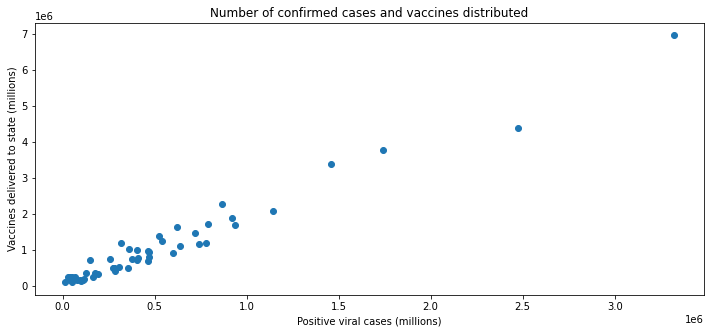

In [15]:
# Scatter plot number of cases and total vaccines delivered to state
plt.figure(figsize=(12,5))
plt.scatter(merge_final.iloc[:,2],merge_final.iloc[:,4])
plt.xlabel('Positive viral cases (millions)')
plt.ylabel('Vaccines delivered to state (millions)')
plt.title("Number of confirmed cases and vaccines distributed")

plt.show()

Text(0, 0.5, 'Vaccines delivered to state (millions)')

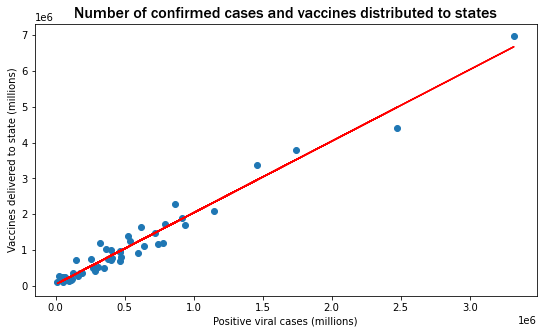

In [17]:
# Add the linear regression equation and line to plot
x = merge_final['positive']
y = merge_final['Tot_Deliv']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
regress_values = x * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.figure(figsize=(9,5))
plt.scatter(x,y)
plt.plot(x,regress_values,"r-")
#plt.savefig('DosesCasesLR.png', dpi=300)
plt.title("Number of confirmed cases and vaccines distributed to states",fontsize=16,fontname="Franklin Gothic Medium")
plt.xlabel('Positive viral cases (millions)')
plt.ylabel('Vaccines delivered to state (millions)')
#plt.show()

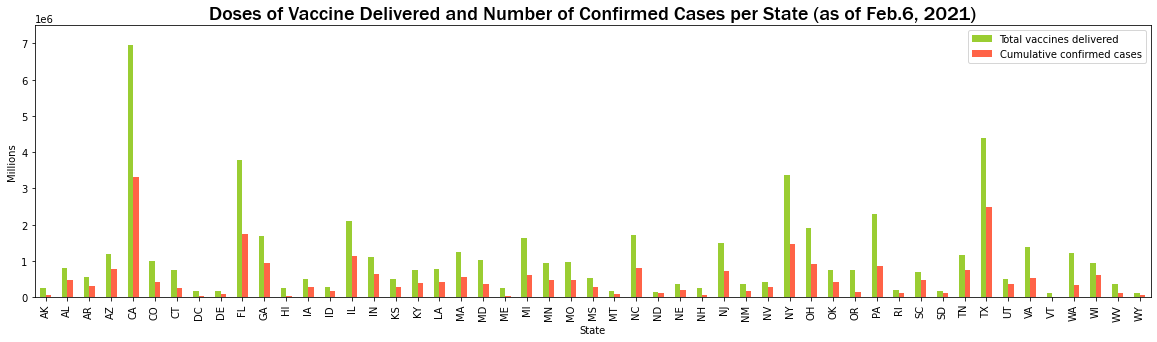

In [18]:
# Let's make a more understandable graphic of the same two variables as used above
Vax = merge_final.plot(x='STABBREV', y=['Tot_Deliv', 'positive'], kind="bar", figsize=(20,5),color={'Tot_Deliv': "yellowgreen", 'positive': "tomato"})
Vax.set_ylim((0, 7500000))
Vax.set_xlabel("State")
Vax.set_ylabel("Millions")
Vax.legend(["Total vaccines delivered", "Cumulative confirmed cases"]);
plt.title("Doses of Vaccine Delivered and Number of Confirmed Cases per State (as of Feb.6, 2021)",fontsize=20,fontname="Franklin Gothic Medium")
plt.savefig('DosesCasesBar.png', dpi=300)

Text(0.5, 1.0, 'Potential Percent of Population with Immunity (as of Feb.6, 2021)')

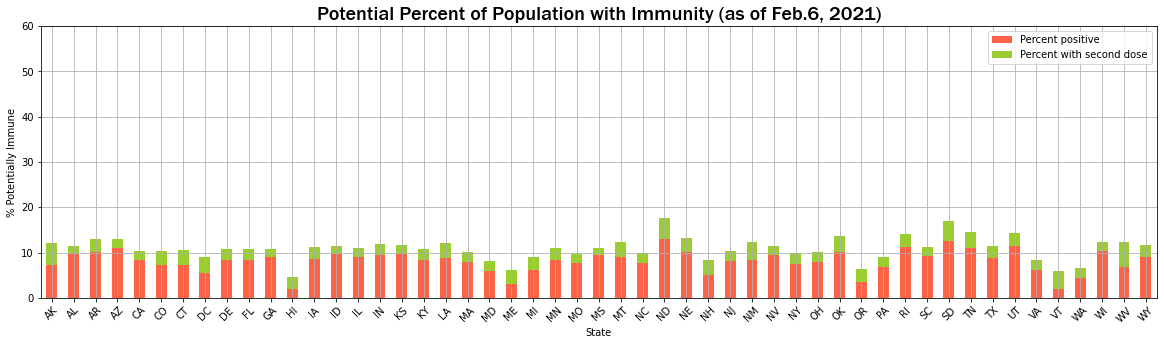

In [19]:
# As a crude measure of immunity status for each state, we show %cases and %vax for each state
# y-axis maximum value set to estimated lower threshold of herd immunity for COVID-19

Immunity = merge_final.plot(x='STABBREV', y=['perpos', 'pervax_2'], kind="bar", stacked = True, figsize=(20,5),color={'pervax_2': "yellowgreen", 'perpos': "tomato"})
Immunity.set_ylim((0, 60))
Immunity.set_xlabel("State")
Immunity.set_ylabel("% Potentially Immune")
Immunity.legend(["Percent positive", "Percent with second dose"]);
plt.xticks(rotation=45 )
plt.grid(True)
plt.title("Potential Percent of Population with Immunity (as of Feb.6, 2021)",fontsize=20,fontname="Franklin Gothic Medium")
#plt.savefig('ImmunityBar.png', dpi=300)